In [323]:
import pandas as pd
import eikon as ek
import matplotlib.pyplot as plt

ek.set_app_key('APP_KEY')
from matplotlib.pyplot import figure


In [ ]:
dates = []
returns_list = []

for YEAR in range(2011,2015):
    for MONTH in range(1,13):
        date = str(YEAR) + (str(0) + str(MONTH) if MONTH < 10 else str(MONTH)) + str(calendar.monthrange(YEAR,MONTH)[1])
        dates.append(date)

for i in range(len(dates)):
    print(dates[i])
    start_date = dates[i]
    end_date = dates[i]
    
    nif100 = ek.get_data('0#.NIFTY100('+start_date + str(')'),['TR.RIC'])

    if(i == 0):
        curr_month = ek.get_data(nif100[0]['Instrument'].str.split('^',expand=True)[0].tolist(),['TR.TotalReturn1Mo.date','TR.TotalReturn1Mo'], {"SDate":start_date, "EDate":end_date})[0]

    weights = curr_month[curr_month['1 Month Total Return'] > 0].dropna(axis=0).sort_values(by='1 Month Total Return')[-10:]
    weights['weights'] = weights['1 Month Total Return']/weights['1 Month Total Return'].sum()
    
    if(i < len(dates)-1):
        start_date = dates[i+1]
        end_date = dates[i+1]
    else:
        break
    next_month = ek.get_data(nif100[0]['Instrument'].str.split('^',expand=True)[0].tolist(),['TR.TotalReturn1Mo.date','TR.TotalReturn1Mo'], {"SDate":start_date, "EDate":end_date})[0]

    portfolio = pd.concat([weights[['Instrument','weights']],next_month],axis=1,names=['Instrument'],join='inner')

    returns = ((1+(portfolio['1 Month Total Return']/100))*portfolio['weights']).sum()
    
    returns_list.append(returns)    
    curr_month = next_month

        
print(returns_list)

In [256]:
PnL = pd.DataFrame({'Date':dates[:-1],'Rets':returns_list})
PnL.loc[len(PnL)] = [dates[-1],1]
PnL['Rets'] = PnL['Rets'].shift(1).fillna(1)
PnL['CumRts'] = PnL['Rets'].cumprod()




In [264]:
year = PnL['Date'][0][:4]
mnth = PnL['Date'][0][4:6]
day= PnL['Date'][0][6:]
stt_date = str(year + "-" + mnth + "-" + day )
year = PnL['Date'][len(PnL)-1][:4]
mnth = PnL['Date'][len(PnL)-1][4:6]
day= PnL['Date'][len(PnL)-1][6:]
end_date = str(year + "-" + mnth + "-" + day )

Benchmark = ek.get_timeseries(rics=['.NSEI'],fields=['CLOSE'],
                            start_date=stt_date,
                            end_date='2020-10-31',
                            interval='daily',corax='adjusted')

Benchmark = Benchmark.resample('M').last()
Benchmark_Returns = Benchmark.pct_change()
Benchmark_Returns.iloc[0]['CLOSE'] = 0

/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:282: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.array(timeseries['dataPoints'])
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:284: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  timestamps = pd.np.array([tz_replacer(value) for value in datapoints[:, timestamp_index]],
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:286: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  datapoints = pd.np.delete(datapoints, pd.np.s_[timestamp_index],
/Users/vipultanwar/Documents/kite/kite/lib/python3.8/site-packages/eikon/time_series.py:209: FutureWarning: T

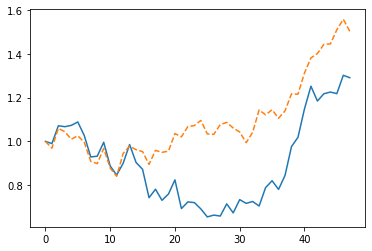

In [259]:

plt.plot(PnL['CumRts'])
plt.plot((((Benchmark_Returns['CLOSE']+1).cumprod()).reset_index())['CLOSE'],'--')
plt.show()

In [343]:
Momentum_strategy_returns = pd.read_csv('2011_2020.csv')[['Date','Rets']]


In [ ]:
_10YT = ek.get_timeseries(rics=['IN10YT=RR'],fields=['CLOSE'],
                            start_date=stt_date,
                            end_date='2020-11-30',
                            interval='monthly',corax='adjusted')

In [353]:
Momentum_strategy_returns.index = _10YT.index

In [ ]:
fig, ax = plt.subplots()
# figure(num=None, figsize=(18, 6), facecolor='w', edgecolor='k')
fig.set_size_inches(22.5, 10.5)

ax2 = ax.twinx()
ax.plot(Momentum_strategy_returns['Rets'].cumprod(),label='Momentum Portfolio [Primary Axis]',color='green',linewidth=3)
ax.plot((((Benchmark_Returns['CLOSE']+1).cumprod())),'--',label = 'Benchmark Index [Primary Axis]',color='orange',linewidth=2)
ax2.plot(_10YT['CLOSE'],'--',label = '10 Y yield',linewidth=0.5)
ax2.plot(_10YT['CLOSE'].rolling(24).mean(),'--',label = '10 Y yield: 2y moving avg',linewidth=0.5)

ax.legend()
ax2.legend()
plt.grid()
plt.show()

In [360]:
plt.savefig('plot.png')

<Figure size 432x288 with 0 Axes>